In [8]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
import matplotlib as mpl
from syd import make_viewer, Viewer

from vrAnalysis.helpers import Timer
from vrAnalysis.helpers import get_place_field, format_spines, vectorRSquared
from vrAnalysis.helpers.vrsupport import _jit_reliability_loo
from vrAnalysis.sessions import create_b2session, B2Session, B2SessionParams
from vrAnalysis.processors import spkmaps as SMPs
from vrAnalysis.processors.support import median_zscore
from vrAnalysis.metrics import FractionActive
from vrAnalysis.processors.spkmaps import Maps, Reliability

plt.rcParams["font.size"] = 18

In [ ]:
# Place field model of activity - (demonstrating that it's a bad model)
mouse_name = "ATL027"
date = "2023-07-27"
session_id = "701"
spks_type = "significant"
session = create_b2session(mouse_name, date, session_id, dict(spks_type=spks_type))
smp = SMPs.SpkmapProcessor(session, params=SMPs.SpkmapParams())

spks = session.spks[:, session.idx_rois]
spks = median_zscore(spks, median_subtract=not session.zero_baseline_spks)
    
placefield_prediction, extras = smp.get_placefield_prediction()

# Filter by valid frames (where there was a valid place field prediction)
spks_valid = spks[extras["idx_valid"]]
pfpred_valid = placefield_prediction[extras["idx_valid"]]

# Potentially filter by reliability
use_reliable = True
reliability_threshold = 0.7
if use_reliable: 
    reliability = smp.get_reliability()
    idx_reliable = np.where(np.any(np.stack([rval > reliability_threshold for rval in reliability.values], axis=0), axis=0))[0]
else:
    idx_reliable = np.arange(spks.shape[1])
spks_valid = spks_valid[:, idx_reliable]
pfpred_valid = pfpred_valid[:, idx_reliable]

# Sort by preferred environment, then place field position
env_maps = smp.get_env_maps()
env_maps.average_trials()
env_maps.filter_rois(idx_reliable)
env_with_strongest_placefield = np.argmax(np.stack([np.nanmax(s, axis=1) for s in env_maps.spkmap]), axis=0)
idx_within_env = []
for ienv in range(len(env_maps.spkmap)):
    idx_rois = np.where(env_with_strongest_placefield == ienv)[0]
    pfidx = get_place_field(env_maps.spkmap[ienv][idx_rois])[1]
    idx_within_env.append(idx_rois[pfidx])

# Master sort by environment then place field position
idx_sort = np.concatenate(idx_within_env)

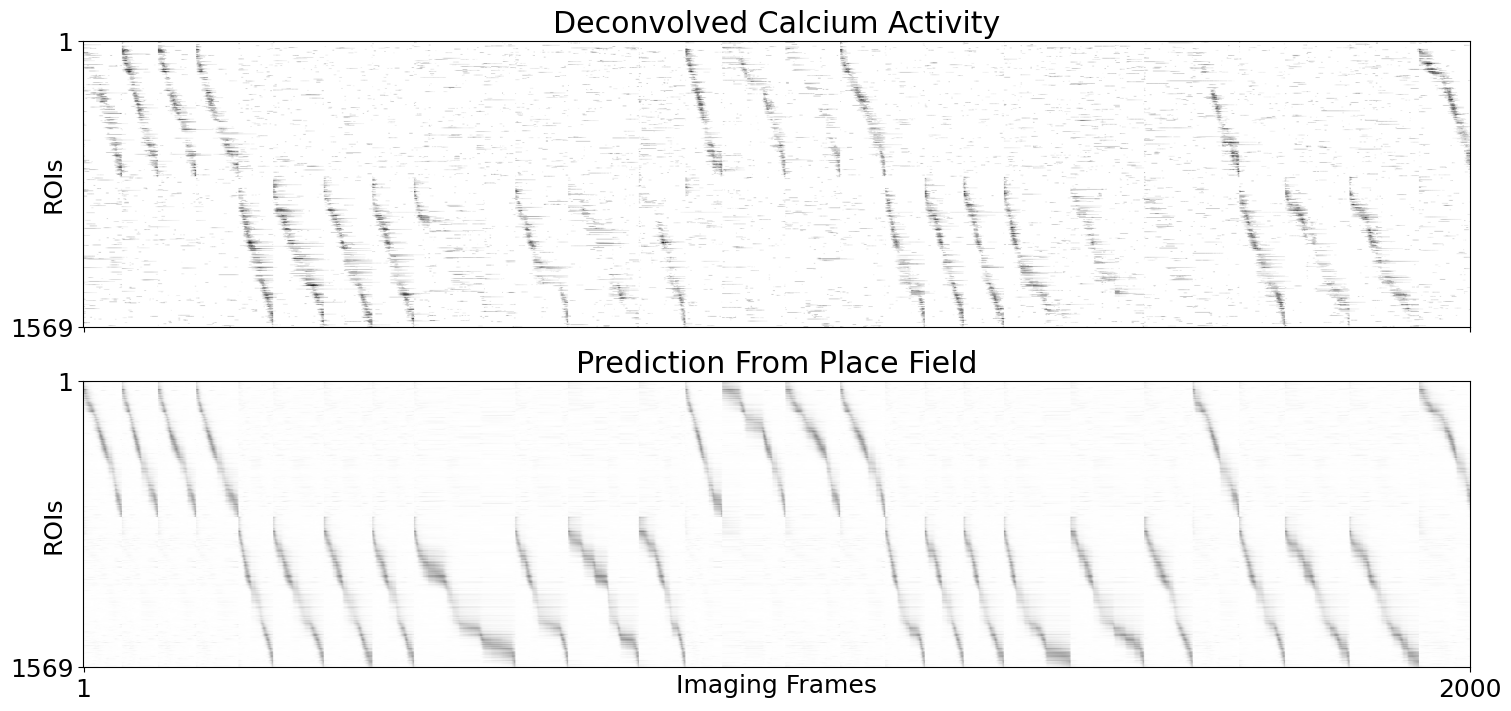

In [ ]:
plt.close('all')

xslice = slice(0, 2000)
num_frames = xslice.stop - xslice.start
num_rois = spks_valid.shape[1]

# Make plot
fig, ax = plt.subplots(2, 1, figsize=(15, 7), layout="constrained", sharex=True, sharey=True)
ax[0].imshow(spks_valid[xslice].T[idx_sort], aspect="auto", cmap="gray_r", vmin=0, vmax=8)
ax[1].imshow(pfpred_valid[xslice].T[idx_sort], aspect="auto", cmap="gray_r", vmin=0, vmax=8)

# Decorate plot
ax[0].set_xticks([0, num_frames-1])
ax[0].set_xticklabels(["1", str(num_frames)])
ax[1].set_xticks([0, num_frames-1])
ax[1].set_xticklabels(["1", str(num_frames)])
ax[0].set_yticks([0, num_rois-1])
ax[0].set_yticklabels(["1", str(num_rois)])
ax[1].set_yticks([0, num_rois-1])
ax[1].set_yticklabels(["1", str(num_rois)])

ax[0].set_title("Deconvolved Calcium Activity")
ax[1].set_title("Prediction From Place Field")
ax[1].set_xlabel("Imaging Frames", labelpad=-20)
ax[0].set_ylabel("ROIs", labelpad=-40)
ax[1].set_ylabel("ROIs", labelpad=-40)

# Show
plt.show()

In [ ]:
# Why don't hippocampal people cross-validate?
mouse_name = "ATL027"
date = "2023-07-27"
session_id = "701"
spks_type = "oasis"
session = create_b2session(mouse_name, date, session_id, dict(spks_type=spks_type))
smp = SMPs.SpkmapProcessor(session, params=SMPs.SpkmapParams())

env_maps = smp.get_env_maps()
env_maps.distcenters = smp.dist_centers
env_maps.pop_nan_positions()
reliability = smp.get_reliability()
fraction_active = np.stack([FractionActive.compute(spkmap, 2, 1) for spkmap in env_maps.spkmap])

class PlaceFieldFocus(Viewer):
    def __init__(self, env_maps: Maps, reliability: Reliability, fraction_active: np.ndarray, dist_edges: np.ndarray):
        self.env_maps = env_maps
        self.reliability = reliability
        self.fraction_active = fraction_active
        self.dist_edges = dist_edges

        self.num_rois = env_maps.spkmap[0].shape[0]
        self.num_envs = len(env_maps.environments)

        self.add_selection("roi", value=0, options=list(range(self.num_rois)))
        self.add_integer("env", value=0, min=0, max=self.num_envs-1)
        self.add_float("reliability_threshold", value=0.7, min=0, max=1)
        self.add_float("fraction_active_threshold", value=0.5, min=0, max=1)
        self.add_float("vmax", value=5, min=1, max=20)
        self.on_change(["env", "reliability_threshold", "fraction_active_threshold"], self.update_filters)

        self.update_filters(self.state)

    def update_filters(self, state):
        env = state["env"]
        reliability_threshold = state["reliability_threshold"]
        fraction_active_threshold = state["fraction_active_threshold"]
        idx_reliable = self.reliability.values[env] > reliability_threshold
        idx_active = self.fraction_active[env] > fraction_active_threshold
        idx_options = np.where(idx_reliable & idx_active)[0]
        self.update_selection("roi", options=list(idx_options))

    def plot(self, state):
        env = state["env"]
        roi = state["roi"]

        # Get this ROI's spkmap and placefield
        spkmap = self.env_maps.spkmap[env][roi]
        placefield = np.nanmean(spkmap, axis=0)

        # Get trial weights and consistency
        trial_weights = np.sqrt(np.mean(spkmap**2, axis=1))
        trial_consistency = _jit_reliability_loo(spkmap[None, ...])[0]
        trial_weights = trial_weights / np.max(trial_weights)
        
        # Filter out trials without activity for plotting
        idx_include = trial_weights > 0
        trial_numbers = np.arange(spkmap.shape[0])[idx_include]
        trial_weights = trial_weights[idx_include] / np.max(trial_weights[idx_include])
        trial_consistency = trial_consistency[idx_include]
        half_trial_number = max(trial_numbers) / 2

        # Some extra plotting parameters
        xlims = [self.dist_edges[0], self.dist_edges[-1]]
        extent = (0, spkmap.shape[1], spkmap.shape[0], 0)
        ymax_pf = np.nanmax(placefield) * 1.2
        cmap = mpl.colormaps["gray_r"]
        norm = plt.Normalize(vmin=0, vmax=state["vmax"])
        values = np.linspace(0, state["vmax"], 100)
        rgba = cmap(norm(values))

        # Create figure and gridspec
        fig = plt.figure(figsize=(5, 6), layout="constrained")
        gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[6, 1])
        ax_spkmap = fig.add_subplot(gs[0, 0])
        ax_placefield = fig.add_subplot(gs[1, 0])
        ax_consistency = fig.add_subplot(gs[0, 1])
        ax_colorbar = ax_spkmap.inset_axes([0.1, 0.15, 0.075, 0.7])

        ax_spkmap.imshow(spkmap, interpolation="none", aspect="auto", cmap="gray_r", vmin=0, vmax=state["vmax"], extent=extent)
        ax_spkmap.set_ylabel("Trials")
        ax_spkmap.set_xlim(xlims[0], xlims[1])
        ax_spkmap.set_ylim(spkmap.shape[0] + 0.5, -0.5)
        format_spines(ax_spkmap, x_pos=-0.02, y_pos=-0.02, xbounds=xlims, xticks=[], yticks=[], tick_length=4, spines_visible=["left"])
        
        ax_placefield.plot(placefield, color="k", linewidth=1.5)
        ax_placefield.set_facecolor(("black", 0.04))
        ax_placefield.set_xlabel("VR Position", labelpad=-10)
        ax_placefield.set_xlim(xlims[0], xlims[1])
        ax_placefield.set_ylim(-0.05, ymax_pf)
        ax_placefield.text(xlims[0], ymax_pf, "Place Field", ha="left", va="top", color="k")
        format_spines(
            ax_placefield, x_pos=-0.02, y_pos=-0.15, xbounds=xlims, xticks=xlims, yticks=[], tick_length=4, spines_visible=["bottom"],
        )

        ax_consistency.scatter(trial_consistency, trial_numbers, color="k", s=5, alpha=trial_weights)
        ax_consistency.set_facecolor(("black", 0.04))
        ax_consistency.set_xlim(-1.05, 1.05)
        ax_consistency.set_ylim(spkmap.shape[0] + 0.5, -0.5)
        ax_consistency.set_xlabel(r"$\sigma$")
        ax_consistency.text(-0.5, half_trial_number, r"$\sigma = \mathrm{corr}(other\ trials)$", ha="center", va="center", rotation=90)
        format_spines(
            ax_consistency, x_pos=-0.02, y_pos=-0.02, xbounds=(-1, 1), xticks=[-1, 0, 1], yticks=[], tick_length=4, spines_visible=["bottom"],
        )

        ax_colorbar.imshow(np.flipud(rgba[:, None, ...]), aspect="auto", extent=(0, 1, 0, 1))
        ax_colorbar.set_xticks([])
        ax_colorbar.set_yticks([])
        ax_colorbar.text(0.5, 0.02, r"0", fontsize=12, ha="center", va="bottom", color="k")
        ax_colorbar.text(0.5, 0.98, f"{int(state['vmax'])}", fontsize=12, ha="center", va="top", color="w")
        ax_colorbar.set_ylabel("Fluorescence ($\sigma$)", fontsize=12)

        return fig

viewer = PlaceFieldFocus(env_maps, reliability, fraction_active, smp.dist_edges)
viewer.show()

c:\Users\Andrew\AppData\Local\miniforge3\envs\vrAnalysis\Lib\site-packages\syd\support.py:162: ParameterUpdateWarning: Warning updating SelectionParameter parameter 'roi': Value 0 not in options, setting to first option (96)
  warn(ParameterUpdateWarning(parameter_name, parameter_type, message))


In [21]:
# Traversal plots
mouse_name = "ATL027"
date = "2023-07-27"
session_id = "701"
spks_type = "oasis"
session = create_b2session(mouse_name, date, session_id, dict(spks_type=spks_type))
smp = SMPs.SpkmapProcessor(session, params=SMPs.SpkmapParams())

env_maps = smp.get_env_maps()
env_maps.pop_nan_positions()
reliability = smp.get_reliability()
fraction_active = np.stack([FractionActive.compute(spkmap, 2, 1) for spkmap in env_maps.spkmap])

class TraversalFocus(Viewer):
    def __init__(self, smp: SMPs.SpkmapProcessor, reliability: Reliability, fraction_active: np.ndarray):
        self.smp = smp
        self.env_maps = env_maps
        self.reliability = reliability
        self.fraction_active = fraction_active
        self.spks = median_zscore(smp.session.spks[:, smp.session.idx_rois], median_subtract=not smp.session.zero_baseline_spks)

        self.num_rois = env_maps.spkmap[0].shape[0]
        self.num_envs = len(env_maps.environments)

        self.add_selection("roi", value=0, options=list(range(self.num_rois)))
        self.add_integer("env", value=0, min=0, max=self.num_envs-1)
        self.add_float("reliability_threshold", value=0.7, min=0, max=1)
        self.add_float("fraction_active_threshold", value=0.5, min=0, max=1)
        self.add_float("vmax", value=12, min=1, max=20)
        self.on_change(["env", "reliability_threshold", "fraction_active_threshold"], self.update_filters)

        self.update_filters(self.state)

    def update_filters(self, state):
        env = state["env"]
        reliability_threshold = state["reliability_threshold"]
        fraction_active_threshold = state["fraction_active_threshold"]
        idx_reliable = self.reliability.values[env] > reliability_threshold
        idx_active = self.fraction_active[env] > fraction_active_threshold
        idx_options = np.where(idx_reliable & idx_active)[0]
        self.update_selection("roi", options=list(idx_options))

    def plot(self, state):
        env = state["env"]
        roi = state["roi"]

        # Get this ROI's traversals and predicted traversals
        width = 20
        traversals, pred_travs = self.smp.get_traversals(roi, env, spks=self.spks, width=width)
        xvals = np.arange(width*2 + 1) - width

        avg_traversal = np.nanmean(traversals, axis=0)
        avg_pred_traversal = np.nanmean(pred_travs, axis=0)
        rms_error = np.sqrt(np.nanmean((pred_travs - traversals)**2, axis=0))
        yavgmax = int(np.ceil(np.max([np.nanmax(avg_traversal), np.nanmax(avg_pred_traversal), np.nanmax(rms_error)]) * 1.05))

        # Some extra plotting parameters
        cmap = mpl.colormaps["gray_r"]
        norm = plt.Normalize(vmin=0, vmax=state["vmax"])
        values = np.linspace(0, state["vmax"], 100)
        rgba = cmap(norm(values))

        cmap_err = mpl.colormaps["bwr"]
        norm_err = plt.Normalize(vmin=-state["vmax"], vmax=state["vmax"])
        values_err = np.linspace(-state["vmax"], state["vmax"], 100)
        rgba_err = cmap_err(norm_err(values_err))

        # Create figure and gridspec
        fig = plt.figure(figsize=(8, 5), layout="constrained")
        gs = fig.add_gridspec(2, 5, width_ratios=[5, 5, 5, 1, 1], height_ratios=[6, 1])
        ax_traversals = fig.add_subplot(gs[0, 0])
        ax_pred_travs = fig.add_subplot(gs[0, 1])
        ax_error = fig.add_subplot(gs[0, 2])
        ax_colorbar = fig.add_subplot(gs[0, 3])
        ax_cbar_error = fig.add_subplot(gs[0, 4])
        ax_avg_traversal = fig.add_subplot(gs[1, 0])
        ax_avg_pred_travs = fig.add_subplot(gs[1, 1])
        ax_rms_error = fig.add_subplot(gs[1, 2])

        extent = (-width, width, traversals.shape[0], 0)
        ax_traversals.imshow(traversals, interpolation="none", aspect="auto", cmap="gray_r", vmin=0, vmax=state["vmax"], extent=extent)
        ax_traversals.set_xlim(-width, width)
        ax_traversals.set_ylabel("PF Traversals\n(Deconvolved)")
        format_spines(ax_traversals, x_pos=-0.02, y_pos=-0.02, xbounds=[-width, width], ybounds=[0, traversals.shape[0]], xticks=[], yticks=[], tick_length=4, spines_visible=["left"])
        
        ax_pred_travs.imshow(pred_travs, interpolation="none", aspect="auto", cmap="gray_r", vmin=0, vmax=state["vmax"], extent=extent)
        ax_pred_travs.set_xlim(-width, width)
        ax_pred_travs.set_ylabel("(PF Pred.)")
        format_spines(ax_pred_travs, x_pos=-0.02, y_pos=-0.02, xbounds=[-width, width], ybounds=[0, traversals.shape[0]], xticks=[], yticks=[], tick_length=4, spines_visible=["left"])

        ax_error.imshow(pred_travs - traversals, interpolation="none", aspect="auto", cmap="bwr", vmin=-state["vmax"], vmax=state["vmax"], extent=extent)
        ax_error.set_xlim(-width, width)
        ax_error.set_ylabel("(Error)")
        format_spines(ax_error, x_pos=-0.02, y_pos=-0.02, xbounds=[-width, width], ybounds=[0, traversals.shape[0]], xticks=[], yticks=[], tick_length=4, spines_visible=["left"])

        ax_avg_traversal.plot(xvals, avg_traversal, color="k", linewidth=1.5)
        ax_avg_traversal.set_xlim(-width, width)
        ax_avg_traversal.set_xlabel("Frames")
        ax_avg_traversal.set_ylabel("Avg")
        format_spines(ax_avg_traversal, x_pos=-0.02, y_pos=-0.02, xbounds=[-width, width], ybounds=[0, yavgmax], xticks=[-width, width], yticks=[0, yavgmax], tick_length=4, spines_visible=["bottom", "left"])
        
        ax_avg_pred_travs.plot(xvals, avg_pred_traversal, color="k", linewidth=1.5)
        ax_avg_pred_travs.set_xlim(-width, width)
        ax_avg_pred_travs.set_xlabel("Frames")
        format_spines(ax_avg_pred_travs, x_pos=-0.02, y_pos=-0.02, xbounds=[-width, width], ybounds=[0, yavgmax], xticks=[-width, width], yticks=[], tick_length=4, spines_visible=["bottom"])

        ax_rms_error.plot(xvals, rms_error, color="k", linewidth=1.5)
        ax_rms_error.set_xlim(-width, width)
        ax_rms_error.set_xlabel("Frames")
        ax_rms_error.text(-width, yavgmax, "RMS\nError", fontsize=12, ha="left", va="top", color="k")
        format_spines(ax_rms_error, x_pos=-0.02, y_pos=-0.02, xbounds=[-width, width], ybounds=[0, yavgmax], xticks=[-width, width], yticks=[], tick_length=4, spines_visible=["bottom"])

        ax_colorbar.imshow(np.flipud(rgba[:, None, ...]), aspect="auto", extent=(0, 1, 0, 1))
        ax_colorbar.set_xticks([])
        ax_colorbar.set_yticks([])
        ax_colorbar.text(0.5, 0.02, r"0", fontsize=12, ha="center", va="bottom", color="k")
        ax_colorbar.text(0.5, 0.98, f"{int(state['vmax'])}", fontsize=12, ha="center", va="top", color="w")
        ax_colorbar.set_ylabel("Fluorescence ($\sigma$)", fontsize=12)

        ax_cbar_error.imshow(np.flipud(rgba_err[:, None, ...]), aspect="auto", extent=(0, 1, 0, 1))
        ax_cbar_error.set_xticks([])
        ax_cbar_error.set_yticks([])
        ax_cbar_error.text(0.5, 0.02, f"-{int(state['vmax'])}", fontsize=12, ha="center", va="bottom", color="w")
        ax_cbar_error.text(0.5, 0.98, f"{int(state['vmax'])}", fontsize=12, ha="center", va="top", color="w")
        ax_cbar_error.set_ylabel("Error ($\sigma$)", fontsize=12)

        return fig

viewer = TraversalFocus(smp, reliability, fraction_active)
viewer.show()

c:\Users\Andrew\AppData\Local\miniforge3\envs\vrAnalysis\Lib\site-packages\syd\support.py:162: ParameterUpdateWarning: Warning updating SelectionParameter parameter 'roi': Value 0 not in options, setting to first option (96)
  warn(ParameterUpdateWarning(parameter_name, parameter_type, message))


C:\Users\Andrew\AppData\Local\Temp\ipykernel_16336\3216790315.py:53: RuntimeWarning: Mean of empty slice
  avg_pred_traversal = np.nanmean(pred_travs, axis=0)
C:\Users\Andrew\AppData\Local\Temp\ipykernel_16336\3216790315.py:54: RuntimeWarning: Mean of empty slice
  rms_error = np.sqrt(np.nanmean((pred_travs - traversals)**2, axis=0))


In [23]:
# Average R-Squared b/w activity and place field prediction model
mouse_name = "ATL027"
date = "2023-07-27"
session_id = "701"
spks_type = "oasis"
session = create_b2session(mouse_name, date, session_id, dict(spks_type=spks_type))
smp = SMPs.SpkmapProcessor(session, params=SMPs.SpkmapParams())

# Get spks and scale same way as spkmaps are computed
spks = session.spks[:, session.idx_rois]
spks = median_zscore(spks, median_subtract=not session.zero_baseline_spks)

# Get spkmaps and reliability
env_maps = smp.get_env_maps()
env_maps.pop_nan_positions()
reliability = smp.get_reliability()

# To make sure the comparison with reliability is fair, use a single environment
env_trials = [omap.shape[0] for omap in env_maps.occmap]
idx_env = 0 #np.argmax(env_trials)

# Get place field prediction
placefield_prediction, extras = smp.get_placefield_prediction()
idx_best_environment = extras["frame_environment_index"] == idx_env
idx_keep = extras["idx_valid"] & idx_best_environment

# Filter by valid frames (where there was a valid place field prediction)
spks_valid = spks[idx_keep]
pfpred_valid = placefield_prediction[idx_keep]

# Measure R-Squared b/w activity and place field prediction for each ROI
r2 = vectorRSquared(pfpred_valid, spks_valid, axis=0)
r2[r2<-1] = np.nan

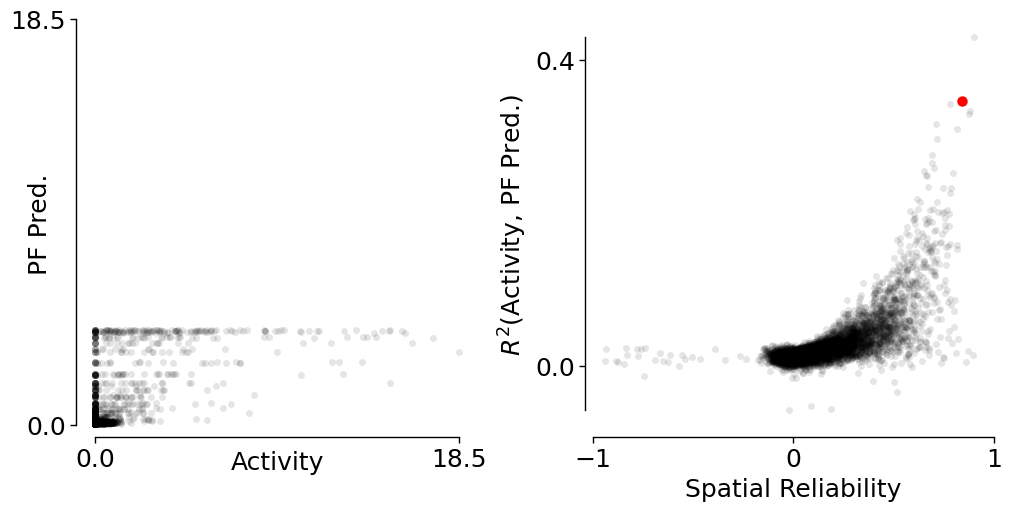

In [45]:
plt.close('all')
fig, ax = plt.subplots(1, 2, figsize=(10, 5), layout="constrained")

ax0max = np.max([np.nanmax(spks_valid.T[96]), np.nanmax(pfpred_valid.T[96])])
ax[0].plot(spks_valid.T[96], pfpred_valid.T[96], markerfacecolor="k", markeredgecolor="none", marker=".", markersize=10, linestyle="none", alpha=0.1)
ax[0].set_xlabel("Activity", labelpad=-15)
ax[0].set_ylabel("PF Pred.", labelpad=-30)
format_spines(ax[0], x_pos=-0.002, y_pos=-0.08, xbounds=[0, ax0max], ybounds=[0, ax0max], xticks=[0, ax0max], yticks=[0, ax0max], tick_length=4, spines_visible=["left", "bottom"])

min_r2 = np.nanmin(r2)
max_r2 = np.nanmax(r2)
max_tick_r2 = np.round(np.nanmax(r2), 1)
ax[1].plot(reliability.values[idx_env], r2, markerfacecolor="k", markeredgecolor="none", marker=".", markersize=10, linestyle="none", alpha=0.1)
ax[1].plot(reliability.values[idx_env][96], r2[96], markerfacecolor="r", markeredgecolor="none", marker=".", markersize=15)
ax[1].set_xlim(-1, 1)
ax[1].set_xlabel("Spatial Reliability")
ax[1].set_ylabel(r"$R^2$(Activity, PF Pred.)")
format_spines(ax[1], x_pos=-0.02, y_pos=-0.02, xbounds=[-1, 1], ybounds=[min_r2, max_r2], xticks=[-1, 0, 1], yticks=[0, max_tick_r2], tick_length=4, spines_visible=["left", "bottom"])

plt.show()